In [ ]:
from datasets import load_from_disk, load_dataset, concatenate_datasets

dataset_name = 'alexshengzhili/SciCapInstructed-graph-only-stage1'
split_lists = ['first_twenty', 
               'twenty_to_forty', 
               'forty2seventy',
               'seventy2ninty', 
                'ninty2onehundred']

dataset_1 = load_dataset(dataset_name, split=split_lists[0])
dataset_2 = load_dataset(dataset_name, split=split_lists[1])
dataset_3 = load_dataset(dataset_name, split=split_lists[2])
dataset_4 = load_dataset(dataset_name, split=split_lists[3])
dataset_5 = load_dataset(dataset_name, split=split_lists[4])

In [8]:
dataset = concatenate_datasets([dataset_1, dataset_2, dataset_3, dataset_4, dataset_5])

Dataset({
    features: ['image_file', 'id', 'caption', 'conversations', 'first_mention', 'response', 'title', 'abstract'],
    num_rows: 352018
})

In [6]:
vali_dataset = load_dataset('alexshengzhili/SciCapInstructed-graph-only-qa', split='1_percent_as_validation')
data = vali_dataset.filter(lambda x: x['q_a_pairs'] is not None and len(x['q_a_pairs']) > 0)


Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/alexshengzhili___parquet/alexshengzhili--SciCapInstructed-graph-only-qa-c5897d2f1995d1be/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/alexshengzhili___parquet/alexshengzhili--SciCapInstructed-graph-only-qa-c5897d2f1995d1be/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-64c68aa07984d39f.arrow


In [13]:
validation_set = set(data['image_file'])

In [15]:
training_dataset_wihtout_validation = dataset.filter(lambda x: x['image_file'] not in validation_set)

In [17]:
len(dataset) - len(training_dataset_wihtout_validation)

3002

In [19]:
import re
import random

# def extract_q_a(s):
#     pairs = []
#     segments = s.split('\n\n')

#     for i in range(0, len(segments)-1, 2):
#         if len(segments[i]) < 1:
#             continue
#         question = segments[i].replace('Question: ', '').strip()
#         answer = segments[i+1].replace('Answer: ', '').strip()
#         pairs.append((question, answer))

#     return pairs
def convert_to_qa_pairs_using_regex(dialog_string):
    # Split the dialog string into segments whenever 'Question:' or 'Answer:' appears
    segments = re.split('Question: |Answer: ', dialog_string)
    
    # Remove any empty strings from the list
    segments = [segment for segment in segments if (len(segment) > 3 and segment != '\n')]
    
    # Group the segments into pairs (question, answer)
    qa_pairs = [(segments[i].strip('\n').strip(), segments[i+1].strip('\n').strip()) for i in range(0, len(segments)-1, 2)]
    valid_pairs = []
    for question, answer in qa_pairs:
        keywords = ['graph', 'diagram', 'figure', 'chart', 'axis', 'plot', 'table', 'image', 'visual', 'illustrat']
        if not any(keyword in question.lower() for keyword in keywords):
            continue
        valid_pairs.append((question, answer))
    return valid_pairs

    
test = False

if test:
    empty_indexes = []
    for _ in range(100):
        random_intgeter = random.randint(0, 50000)
        q_a_pairs = convert_to_qa_pairs_using_regex(training_dataset_wihtout_validation[random_intgeter]['response'])
        if len(q_a_pairs) < 1:
            empty_indexes.append(random_intgeter)


In [27]:
import random

    
def convert_to_conversations(example, insert_context= False):
    q_a_pairs = convert_to_qa_pairs_using_regex(example['response'])
    conversations = []
    
    random_prompt = ''
    for i, qa in enumerate(q_a_pairs):
        Question, Answer = qa
        
        # for the first round, use the random prompt
        if i == 0:
            if insert_context:
                Question = example['title'] + ' ' + example['caption'] + ' ' + Question
            if random.random() < 0.5:
                random_prompt = f"{Question}\n<image>"
            else:
                random_prompt = f"<image>\n{Question}"
            
            conversations.append({"from": "human", "value": random_prompt})
        else: 
            # for subsequent rounds, just use the question and answer
            conversations.append({"from": "human", "value": Question})
        conversations.append({"from": "gpt", "value": Answer})
        
    return conversations, q_a_pairs

def convert_example(example):
    conversations, q_a_pairs = convert_to_conversations(example)
    example['conversations'] = conversations
    example['q_a_pairs'] = q_a_pairs
    return example


def filter_for_non_helpful_instructions(example):
    item = example['response']
    if ('question' not in item.lower() or
        'answer' not in item.lower()):
        return False
    return True

isTrain = True
isVal = False


if isTrain: 
    
    # test_train = train[:100]
    filtered_train = training_dataset_wihtout_validation.filter(filter_for_non_helpful_instructions)
    converted_conversations = filtered_train.map(convert_example, num_proc=4)
    converted_conversations = converted_conversations.filter(lambda x: len(x['q_a_pairs']) > 0)
if isVal:
    filtered_validation = validation_one_percent.filter(filter_for_non_helpful_instructions)
    converted_conversations_validation = validation_one_percent.map(convert_example)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/alexshengzhili___parquet/alexshengzhili--SciCapInstructed-graph-only-stage1-cb3c63a49a8170bf/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-236532537149a7e0.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/alexshengzhili___parquet/alexshengzhili--SciCapInstructed-graph-only-stage1-cb3c63a49a8170bf/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-ecbdb8cfa65c3464_*_of_00004.arrow


In [28]:
len(training_dataset_wihtout_validation) - len(converted_conversations)
print(f'Number of examples in the training set BEFORE converstion: {len(training_dataset_wihtout_validation)}')
print(f'Number of examples in the training set AFTER converstion: {len(converted_conversations)}')

Number of examples in the training set BEFORE converstion: 349016
Number of examples in the training set AFTER converstion: 295602


## Let us calculate the average number of turns, and the average token 



In [30]:
# calcualte length
def calculate_length(dataset):
    lengths = []
    for example in dataset:
        lengths.append(len(example['q_a_pairs']))
    return lengths

lengths = calculate_length(converted_conversations)

In [34]:
np.mean(lengths), np.std(lengths), np.max(lengths), np.min(lengths)

(2.230394246317684, 1.1759158960203515, 8, 1)

Text(0.5, 1.0, 'Distribution of number of Quesiton-Answer pairs')

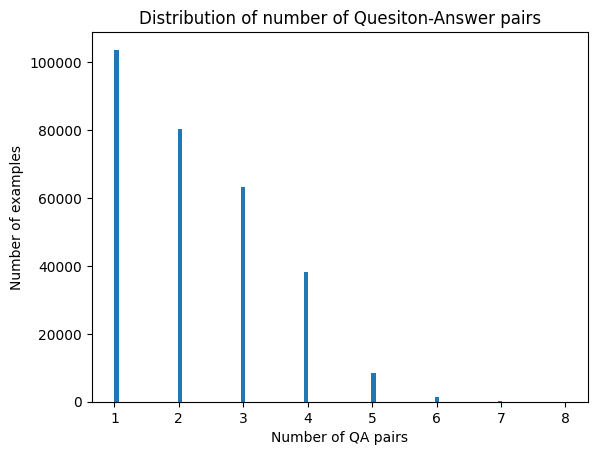

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(lengths, bins=100)
plt.xlabel('Number of QA pairs')
plt.ylabel('Number of examples')
plt.title('Distribution of number of Quesiton-Answer pairs')


In [36]:
converted_conversations[0]

{'image_file': '1610.06815v1-Figure4-1.png',
 'id': '1610.06815v1-Figure4-1',
 'caption': 'Fig. 4. Learning error for different learning rates.',
 'conversations': [{'from': 'human',
   'value': 'How does the graph in Figure 4 illustrate this relationship?\n<image>'},
  {'from': 'gpt',
   'value': 'The graph in Figure 4 shows reconstruction errors for a Gaussian-Bernoulli RBM with a structure of 312-600. The momentum value is set to 0.9 and the learning rate values are 0.005, 0.01, and 0.018. It can be observed that the error decreased faster if a larger learning rate was used. However, when the learning rate was increased to 0.02, the training failed to converge. This suggests that a larger learning rate may not always be better for RBM learning.'}],
 'first_mention': '1) Effects of Momentum and Learning Rate in Pretraining: A good combination of learning rate and momentum is crucial for the convergence of RBM learning. Usually, a small value for the learning rate and a large value fo

In [38]:
from utilities import num_tokens_from_messages


total_qa_token = num_tokens_from_messages(converted_conversations['conversations'])
total_qa_token

In [41]:
total_qa_token, avg_qa_token = total_qa_token, total_qa_token / len(converted_conversations)

print(f'Total number of tokens in the training set: {total_qa_token}')
print(f'Average number of tokens per example in the training set: {avg_qa_token}')


Total number of tokens in the training set: 72269922
Average number of tokens per example in the training set: 244.48387358678224


In [ ]:
total_number_of_tokens = 0

In [42]:
token_length_per_example = [num_tokens_from_messages(example['q_a_pairs']) for example in converted_conversations]

In [45]:
sum(token_length_per_example)

59097618

In [44]:
np.mean(token_length_per_example), np.std(token_length_per_example), np.max(token_length_per_example), np.min(token_length_per_example)

(199.92293015608826, 97.16691157800025, 1004, 27)

# also per question and answer pair, let us calculate the length
[num_tokens_from_messages(example['q_a_pairs']) /  for example in converted_conversations]


In [46]:
average_token_per_turn = [num_tokens_from_messages(example['q_a_pairs']) / len(example['q_a_pairs']) for example in converted_conversations]


In [47]:
np.mean(average_token_per_turn), np.std(average_token_per_turn), np.max(average_token_per_turn), np.min(average_token_per_turn)

(95.51090327454448, 32.71353797295097, 681.0, 27.0)

Upload the dta to huggingface 

In [51]:
destination = 'alexshengzhili/SciCap-instruct-multiturn-filtered'


converted_conversations.push_to_hub(destination, use_authenticated_user=True)


Pushing dataset shards to the dataset hub: 100%|██████████| 4/4 [00:56<00:00, 14.08s/it]


# The rest if previous legacy code

In [66]:
import numpy as np
np.median(length), np.mean(length)

(2.0, 2.241505662891406)

In [86]:
len(converted_conversations[180]['conversations'])

8

# Eval construction only/

In [133]:
def convert_to_only_question(example):
    Question, _ = extract_q_a(example['response'])
    example["text"]= Question
    example["category"] = "conv"
    return example

filtered_validation = validation_one_percent.filter(filter_for_non_helpful_instructions)
validation_converted = filtered_validation.map(convert_to_only_question)

Loading cached processed dataset at /home/jupyter/generative-ai/validation_with_response_fix_onepercenttest/cache-c35e1a157f242711.arrow
Loading cached processed dataset at /home/jupyter/generative-ai/validation_with_response_fix_onepercenttest/cache-2bf4b118c5d958a0.arrow


In [137]:
validation_converted_for_eval = []

# Iterate over the dataset
for record in tqdm(validation_converted):
    # Apply some processing function to your data, if needed
    # processed_data = process_numpy(record)

    # If no processing is needed, directly append the record
    processed_data = dict(image=record['image_file'], text=record['text'], category=record['category'])

    # Append the data to the list
    validation_converted_for_eval.append(processed_data)

100%|██████████| 91/91 [00:00<00:00, 9365.50it/s]


In [138]:
# Let us also construct the 'detail' questions based on 1% of validation set

validation = load_from_disk('validation_with_response_fix')

In [139]:
validation_last_one_percent = validation[9100:]

In [140]:
detailed_prompt_list = [
    "Describe the following image in detail",
    "Provide a detailed description of the given image",
    "Give an elaborate explanation of the image you see",
    "Share a comprehensive rundown of the presented image",
    "Offer a thorough analysis of the image",
    "Explain the various aspects of the image before you",
    "Clarify the contents of the displayed image with great detail",
    "Characterize the image using a well-detailed description",
    "Break down the elements of the image in a detailed manner",
    "Walk through the important details of the image",
    "Portray the image with a rich, descriptive narrative",
    "Narrate the contents of the image with precision",
    "Analyze the image in a comprehensive and detailed manner",
    "Illustrate the image through a descriptive explanation",
    "Examine the image closely and share its details",
    "Write an exhaustive depiction of the given image"
]

import random 
list_of_deatil_prompt = []
for i in range(len(validation_last_one_percent['image_file'])):
    image = validation_last_one_percent['image_file'][i]
    prompt = random.choice(detailed_prompt_list)
    list_of_deatil_prompt.append(dict(image=image, text=prompt, category="detail"))


In [141]:
combined_list = validation_converted_for_eval + list_of_deatil_prompt

In [142]:
for i in range(len(combined_list)):
    combined_list[i]['question_id'] = i

# This saves the dataset to proper json format

In [99]:
from tqdm import tqdm
import json
def convert_dataset_into_json(converted_conversations, json_filename):
    # Initialize a list to save processed data
    all_data = []

    # Iterate over the dataset
    for record in tqdm(converted_conversations):
        # Apply some processing function to your data, if needed
        # processed_data = process_numpy(record)

        # If no processing is needed, directly append the record
        processed_data = record

        # Append the data to the list
        all_data.append(processed_data)

    # Save all the data to a line-separated JSON file
    with open(json_filename, "w") as output_file:
        json.dump(all_data, output_file, indent=4)
            
# convert_dataset_into_json(combined_list, 'data/eval.json')
convert_dataset_into_json(converted_conversations, 'first_twenty_dictionary.json')

100%|██████████| 56520/56520 [00:08<00:00, 6612.09it/s]


In [144]:
# Use for train

convert_dataset_into_json(combined_list, 'data/eval.json')

100%|██████████| 256/256 [00:00<00:00, 1374829.48it/s]
